## OpenAI Assistant API for file search
The Assistants API allows you to build AI assistants within your own applications. An Assistant has instructions and can leverage models, tools, and files to respond to user queries. It supports "Code Interpreter", "File Search", and "Function calling".
- Create a Assistant, add files, define tools
- Create a Thread when users start a conversation
- Create a Message when user sends the message
- Run the threads to get response by calling the model and tools

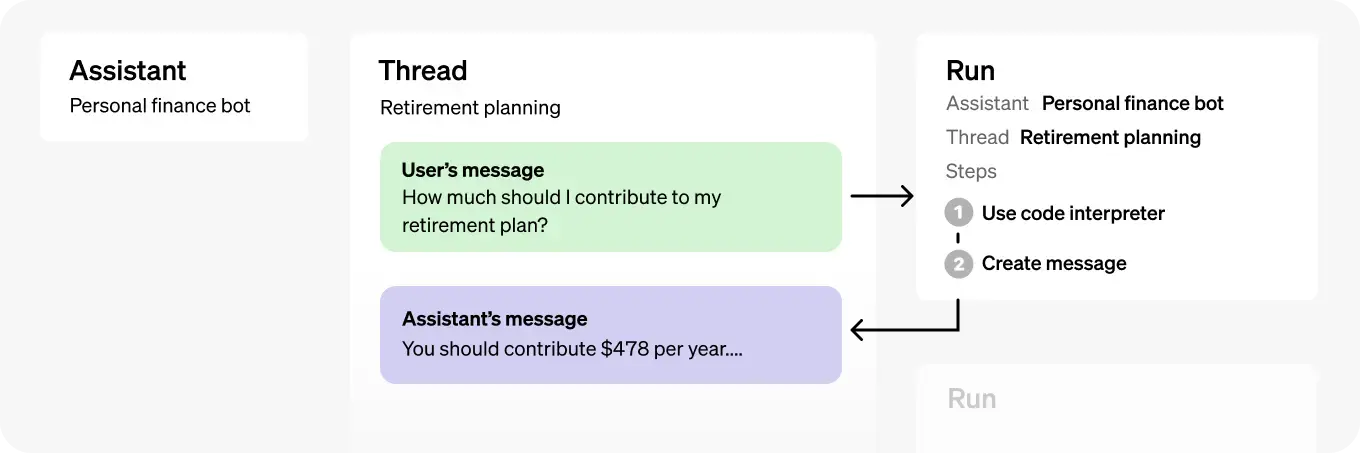


- $\color{green}{Assistant}$:	Purpose-built AI that uses OpenAI’s models and calls tools
- $\color{green}{Thread}$:	A conversation session between an Assistant and a user. Threads store Messages and automatically handle truncation to fit content into a model’s context.
- $\color{green}{Message}$:	A message created by an Assistant or a user. Messages can include text, images, and other files. Messages stored as a list on the Thread.
- $\color{green}{Run}$:	An invocation of an Assistant on a Thread. The Assistant uses its configuration and the Thread’s Messages to perform tasks by calling models and tools. As part of a Run, the Assistant appends Messages to the Thread.
- $\color{green}{Run \ Step}$:	A detailed list of steps the Assistant took as part of a Run. An Assistant can call tools or create Messages during its run. Examining Run Steps allows you to introspect how the Assistant is getting to its final results.

#### This code is for demonstrating how to create a ASSISTANT via Assistant API. Once the assistant is created, DO NOT CREATE AGAIN. Visist it via ASSISTANT ID

### Step 1 Create a assistant

In [15]:
import os
from openai import OpenAI
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

assistant = client.beta.assistants.create(
  name="Personal assistant",
  instructions="You are an personal expert. Use you knowledge base to answer questions about personal information.",
  tools=[{"type": "file_search"}],
  model="gpt-4o",
)

### Step 2 Upload files and add them to a Vector Store

In [3]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Project root directory (adjust based on where your script is located)
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..', '..'))

# Add project root to system path
sys.path.append(project_root)
project_root

'/Users/tianyuliu/Code/llm/NLP_examples'

In [4]:


# Create a vector store caled "Financial Statements"
vector_store = client.beta.vector_stores.create(name="Personal Documents")
 
# Ready the files for upload to OpenAI
file_paths = [project_root+"/data/personal/Resume_applied_scientist.pdf", ]
              # project_root+"/data/healthcare/oracle-cloud-infrastructure-for-healthcare.pdf", ]
file_streams = [open(path, "rb") for path in file_paths]
 
# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams)
 
# You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)

completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


### Step 3 Update a Assistant with files

In [10]:
assistant = client.beta.assistants.update(
  assistant_id=assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

### Step 4 Create a Thread

You can also attach files as Message attachments on your thread. Doing so will create another vector_store associated with the thread, or, if there is already a vector store attached to this thread, attach the new files to the existing thread vector store. When you create a Run on this thread, the file search tool will query both the vector_store from your assistant and the vector_store on the thread.

In [11]:
# # Upload the user provided file to OpenAI
# message_file = client.files.create(
#   file=open(project_root+"/data/healthcare/Resume_applied_scientist.pdf", "rb"), purpose="personal assistants"
# )
 
# Create a thread and attach the file to the message
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "How many working experience does Tianyu Liu have?",
      # # Attach the new file to the message.
      # "attachments": [
      #   { "file_id": message_file.id, "tools": [{"type": "file_search"}] }
      # ],
    }
  ]
)
 
# The thread now has a vector store with that file in its tool resources.
print(thread.tool_resources.file_search)

None


### Step 5.1 Create a Run and check the output without streaming

In [12]:
# Use the create and poll SDK helper to create a run and poll the status of
# the run until it's in a terminal state.

run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id, assistant_id=assistant.id
)

messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))
messages


[Message(id='msg_eAIrkiMX8zxz4BCMj0STGsB2', assistant_id='asst_neKIxzX9azeMqYlnYYT700AT', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[FileCitationAnnotation(end_index=396, file_citation=FileCitation(file_id='file-j7ZYjgIW5kjYEy3iklxjMfGT'), start_index=362, text='【4:0†Resume_applied_scientist.pdf】', type='file_citation')], value='Tianyu Liu has the following working experience:\n\n1. **Applied Scientist at NinjaTech AI**: A 3-month contract from March 2024 to June 2024.\n2. **Data Scientist at Munich Reinsurance Australia**: A 6-month contract from August 2023 to February 2024.\n3. **Research Assistant at Australia AI Institute, University Technology Sydney**: From August 2019 to July 2023【4:0†Resume_applied_scientist.pdf】. \n\nThis totals to approximately 4 years and 5 months of working experience.'), type='text')], created_at=1729170626, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id=

In [13]:
print(messages[0].content[0].text)

Text(annotations=[FileCitationAnnotation(end_index=396, file_citation=FileCitation(file_id='file-j7ZYjgIW5kjYEy3iklxjMfGT'), start_index=362, text='【4:0†Resume_applied_scientist.pdf】', type='file_citation')], value='Tianyu Liu has the following working experience:\n\n1. **Applied Scientist at NinjaTech AI**: A 3-month contract from March 2024 to June 2024.\n2. **Data Scientist at Munich Reinsurance Australia**: A 6-month contract from August 2023 to February 2024.\n3. **Research Assistant at Australia AI Institute, University Technology Sydney**: From August 2019 to July 2023【4:0†Resume_applied_scientist.pdf】. \n\nThis totals to approximately 4 years and 5 months of working experience.')


In [14]:
message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

Tianyu Liu has the following working experience:

1. **Applied Scientist at NinjaTech AI**: A 3-month contract from March 2024 to June 2024.
2. **Data Scientist at Munich Reinsurance Australia**: A 6-month contract from August 2023 to February 2024.
3. **Research Assistant at Australia AI Institute, University Technology Sydney**: From August 2019 to July 2023[0]. 

This totals to approximately 4 years and 5 months of working experience.
[0] Resume_applied_scientist.pdf


### Step 5.2 Create a Run and check the output with streaming

In [25]:
from typing_extensions import override
from openai import AssistantEventHandler, OpenAI
 
client = OpenAI()
 
class EventHandler(AssistantEventHandler):
    @override
    def on_text_created(self, text) -> None:
        print(f"\nassistant > ", end="", flush=True)

    @override
    def on_tool_call_created(self, tool_call):
        print(f"\nassistant > {tool_call.type}\n", flush=True)

    @override
    def on_message_done(self, message) -> None:
        # print a citation to the file searched
        message_content = message.content[0].text
        annotations = message_content.annotations
        citations = []
        for index, annotation in enumerate(annotations):
            message_content.value = message_content.value.replace(
                annotation.text, f"[{index}]"
            )
            if file_citation := getattr(annotation, "file_citation", None):
                cited_file = client.files.retrieve(file_citation.file_id)
                citations.append(f"[{index}] {cited_file.filename}")

        print(message_content.value)
        print("\n".join(citations))


# Then, we use the stream SDK helper
# with the EventHandler class to create the Run
# and stream the response.

with client.beta.threads.runs.stream(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Please address the user as Jane Doe. The user has a premium account.",
    event_handler=EventHandler(),
) as stream:
    stream.until_done()


assistant > If you have any more questions, Jane Doe, feel free to ask!

